## 통계 활용대회
### 토픽모델링을 통한 고용형태 변화 탐색

#### - 주요 패키지와 데이터 불러오기

In [37]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# 글씨체
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/H2HDRM.TTF').get_name()
rc('font', family=font_name)

# 데이터 불러오기 각각 19년 20년 기사
data2019 = pd.read_excel('2019gisa.xlsx')
data2020 = pd.read_excel('2020gisa.xlsx')

# text 형식의 데이터 list 형태로 바꿔 주기
data2019['words'] = [i.replace("'", "").replace('[', '').replace(']', '').replace(' ', '').split(',') for i in
                     list(data2019['words'])]  # words가 텍스트 형식으로 되어 있을 경우
data2020['words'] = [i.replace("'", "").replace('[', '').replace(']', '').replace(' ', '').split(',') for i in
                     list(data2020['words'])]  # words가 텍스트 형식으로 되어 있을 경우

#### - 분석대상 키워드 별로 기사량 확인하기

In [10]:
# 분석대상 키워드 (분석대상 키워드는 통계청 뉴스기반 검색사이트를 사용하여 임의로 정했음)
keyword_list = ['유통', '청년', '근로자', '노동자', '배달', '재택근무',
                '화상회의', '택배', '출퇴근', '유연근무제']

# 키워드별 기사량 증감율 확인하기
# 년도별 키워드별 기사량 확인하기
count2019 = []
for k in keyword_list:
    j = 0
    for i in data2019['words']:
        if k in i:
            j += 1
    count2019.append(j)

count2020 = []
for k in keyword_list:
    j = 0
    for i in data2020['words']:
        if k in i:
            j += 1
    count2020.append(j)

keyword_data = pd.DataFrame({'keyword': keyword_list, 'count2019': count2019, 'count2020': count2020})
keyword_data['rate'] = [(i - j) / j for i, j in zip(count2020, count2019)]  # 증가율 계산하기

keyword_data

,keyword,count2019,count2020,rate
0,유통,3136,3122,-0.004464
1,청년,1717,1456,-0.152009
2,근로자,1184,1932,0.631757
3,노동자,752,1235,0.642287
4,배달,534,1353,1.533708
5,재택근무,8,1558,193.750000
6,화상회의,19,739,37.894737
7,택배,264,615,1.329545
8,출퇴근,310,499,0.609677
9,유연근무제,49,115,1.346939


#### - 증감율 시각화 하기

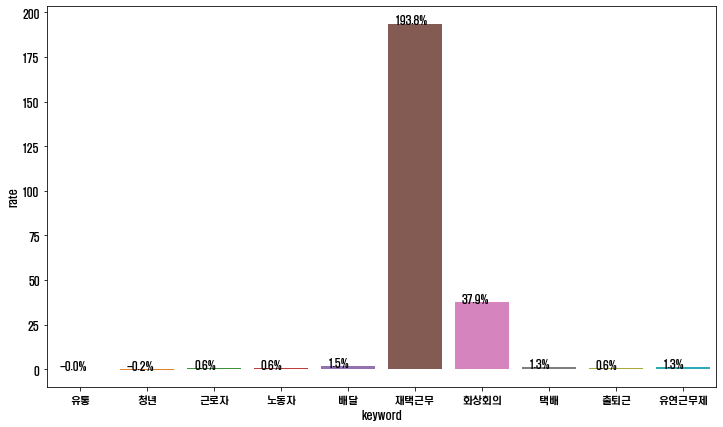

In [14]:
# 그래프를 그려 증감율 확인하기
plt.figure(figsize=(12,7))
plt.plot()
g = sns.barplot(x=keyword_data['keyword'], y=keyword_data['rate'])
for i, j in enumerate(keyword_data['rate']):
    g.text(x=i - 0.3, y=j, s="{:.1f}%".format(j))

#### - 키워드에 따른 뉴스 분류를 위해 (1) 사전방식 을 이용

In [16]:
# 키워드에 따른 뉴스분류를 사전방식과 word2vec 방법을 이용
# 사전 방식으로 뉴스 분류 (포함어 방식)
for i in keyword_list:
    data2019[i] = 0
    data2020[i] = 0

# 뉴스 기사에 키워드가 있으면 1, 아니면 0으로 라벨링
for i in keyword_list:
    for j in range(len(data2019)):
        if i in data2019['words'][j]:
            data2019[i][j] = 1
    for j in range(len(data2020)):
        if i in data2020['words'][j]:
            data2020[i][j] = 1

# 잘 되었는지 확인
print(data2019['청년'].value_counts())
print(data2020['청년'].value_counts())

<ipython-input-16-f574b8e764d6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2019[i][j] = 1
<ipython-input-16-f574b8e764d6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2020[i][j] = 1


0    59009
1     1717
Name: 청년, dtype: int64
0    62205
1     1456
Name: 청년, dtype: int64


#### - word2vec 모델 만들기

In [20]:
# word2vec 분석하기
from gensim.models import KeyedVectors
try:
    embedding_model = KeyedVectors.load_word2vec_format("new_w2v")  # 모델 로드
except:
    embedding_model = Word2Vec(pd.concat([data2020['words'], data2019['words']]), vector_size=100, window=5,
                               min_count=30,
                               workers=4, epochs=50)
    embedding_model.wv.save_word2vec_format('new_w2v')  # 모델 저장

In [36]:
pd.concat([data2020['words'], data2019['words']])
embedding_model.wv.index_to_key
data2020['words']

0        ['코로나', '확산', '오늘', '주년', '삼일절', '기념', '식이', '...
1        ['정부', '공모', '사업', '지난해', '발굴', '홍춘', '삼척', '삼...
2        ['대구', '지역', '코로나', '진자', '급증', '신천지', '연관', '...
3        ['이미지', '출처', '아시아', '경제', '김현정', '신종', '코로나바이...
4        ['김선경', '수출', '코로나', '악재', '불구', '개월', '증가', '...
                               ...                        
63656    ['공주', '페이', '할인', '지원', '공영', '주차장', '무료', '개...
63657    ['이상', '창업', '배출', '한남대', '창업', '원단', '개최', '나...
63658    ['한국', '경제', '이영호', '정부', '신종', '코로나바이러스', '감염...
63659    ['전공', '무기한', '파업', '지속', '서울', '종로구', '서울대', ...
63660    ['코로나', '확산', '정부', '수도권', '거리', '두기', '강화', '...
Name: words, Length: 63661, dtype: object

In [ ]:
embedding_model.wv.most_similar('유통', topn=10)


# 기사들이 해당 키워드와 얼마나 관련이 있는지 점수를 매기는 함수 word2vec 유사도 점수를 활용
def scoring(word, keyword):
    avg_dist = []
    dist = []
    dist_dist = []
    for i in tqdm(range(len(word))):
        for k in word[i]:
            try:
                # 비교하여 similarity 구하기
                dist_dist.append(embedding_model.wv.similarity(keyword, k))
            except:
                dist_dist.append(0)
            dist.append(np.array(dist_dist))
            dist_dist = []
        avg_dist.append(np.mean(dist))
        dist = []
    return avg_dist


for i in keyword_list:
    globals()['data2019' + i] = data2019[data2019[i] == 1].reset_index(drop=True)
    globals()['data2019' + i]['score'] = scoring(globals()['data2019' + i]['words'], i)
    globals()['data2020' + i] = data2020[data2020[i] == 1].reset_index(drop=True)
    globals()['data2020' + i]['score'] = scoring(globals()['data2020' + i]['words'], i)
    
data2019

#### 각 기사들이 키워드와 얼마나 관련이 있는지 코사인 유사도를 이용해 스코어링

In [ ]:

# 나눠진 데이터 별로 토픽모델링 실시
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

def topic(word):
    texts = word
    id2word = corpora.Dictionary(texts)
    corpus = [id2word.doc2bow(text) for text in texts]

    def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
        coherence_values = []
        model_list = []
        for num_topics in tqdm(range(start, limit, step)):

            model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        return model_list, coherence_values
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2,
                                                            limit=20, step=1)

    # Show graph
    limit = 20; start = 2; step = 1;
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    print(coherence_values.index(max(coherence_values)) + 2,'개의 주제가 이상적')
    #print(word)
    #주제 dataframe화 하기
    coherence_values.index(max(coherence_values))
    optimal_model = model_list[coherence_values.index(max(coherence_values))]
    topic_dic = {}
    for i in range(coherence_values.index(max(coherence_values)) + 2):
        words2 = optimal_model.show_topic(i, topn=20)
        topic_dic['topic ' + '{:02d}'.format(i + 1)] = [i[0] for i in words2]
    da = pd.DataFrame(topic_dic)
    return da

a = topic(data2019근로자['words'])

# 나뉘어진 데이터 프레임 별로 토픽모델링
for i in keyword_list:
    globals()['topic2020' + i] = topic(globals()['data2020' + i]['words'])

# 이후 토픽모델링 결과를 살펴보고 고용 트렌드 변화 예측
